In [1]:
# Load libraries
import os
import getpass
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# Own Liberay
import xgboost_model as model

# XGBoost Forecasting

**How to read this notebook:**

1. **Data**  
   We load and prepare the dataset for modeling, including setting the target (inflation) and explanatory variables.

2. **Forecast**  
   We apply the XGBoost model to forecast inflation *h* months ahead from a given point in time (*last_observation_date*), using a fixed training window of *window_length* months.
   
3. **Rolling Forecasts**  
   We implement a multi-horizon rolling window approach that mimics real-world forecasting. At each point in time (e.g., January 2023), the model is trained on the most recent 96 months of data and used to forecast inflation 1 to 12 months ahead. The next month (e.g., February 2023), the window moves forward by one month, and the process repeats.  
   This approach is inspired by Garcia et al. (2017).

4. **Model Evaluation**  
    Forecast accuracy is assessed using standard performance metrics such as Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), evaluated across all horizons.
   
      4.1. **Forecast Accuracy by Horizon** \
      Report MAE and RMSE per horizon using the rolling forecasts.

      4.2. **Forecast Details (Example: 1-month ahead)** \
      Show detailed forecast vs. actual, errors and squared errors for a given horizon (e.g. h = 0).

## 1. Data

In [4]:
# Navigate to data folder
os.chdir('../Data')

# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 221)


In [5]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 220)


# 2. Forecast

We now generate forecasts using the XGBoost model within a rolling window framework.  
At each step, the model is trained on the most recent 108 months of data and produces forecasts for the next 12 months.  
The last date used for model training is set to **December 2024**, meaning we forecast inflation for the period from January to December 2025.


In [8]:
xgb_result = model.XGBoost_Forecaster(
    X=X,
    y=y,
    forecast_horizon=12,
    last_observation_date="2024-12-01",
    scaler=scaler,
    window_length=108,
    verbose=True # None = nothing is being printed
)


=== Horizon h=1 ===
Number of training observations: 108
Number of features: 220

=== Horizon h=2 ===
Number of training observations: 107
Number of features: 220

=== Horizon h=3 ===
Number of training observations: 106
Number of features: 220

=== Horizon h=4 ===
Number of training observations: 105
Number of features: 220

=== Horizon h=5 ===
Number of training observations: 104
Number of features: 220

=== Horizon h=6 ===
Number of training observations: 103
Number of features: 220

=== Horizon h=7 ===
Number of training observations: 102
Number of features: 220

=== Horizon h=8 ===
Number of training observations: 101
Number of features: 220

=== Horizon h=9 ===
Number of training observations: 100
Number of features: 220

=== Horizon h=10 ===
Number of training observations: 99
Number of features: 220

=== Horizon h=11 ===
Number of training observations: 98
Number of features: 220

=== Horizon h=12 ===
Number of training observations: 97
Number of features: 220

Forecasted mont

In [9]:
xgb_result

,Date,Inflation forecast,Horizon
0,2025-01-01,1.884825,0
1,2025-02-01,1.855855,1
2,2025-03-01,3.077746,2
3,2025-04-01,4.114525,3
4,2025-05-01,3.582557,4
5,2025-06-01,3.390279,5
6,2025-07-01,4.214467,6
7,2025-08-01,6.542736,7
8,2025-09-01,7.659441,8
9,2025-10-01,5.667697,9


The table below shows the 12-month-ahead inflation forecasts produced by the XGBoost model, starting from January 2025.  
Each row corresponds to a forecast for a specific month and its associated forecast horizon (0 = 1 month ahead, 11 = 12 months ahead).

# 3. Rolling forecasts

In [12]:
xgb_rolling_result = model.run_rolling_forecast(
    X=X,
    y=y,
    forecast_horizon=12,
    start_date="2023-01-01",
    end_date="2024-12-01",
    window_length=108,
)

# 4. Model Evaluation
## 4.1 Forecast Accuracy by Horizon

We now evaluate the performance of the rolling forecasts across different horizons.

The table below shows the **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** for each forecast horizon from 1 to 12 months ahead (h = 0 to 11).  
These metrics are computed by comparing the model's predicted inflation values with the actual observed values across all rolling forecast iterations.

`N_obs` indicates how many forecasts were available for each horizon, which decreases as the horizon increases due to the fixed end date (December 2024).


In [15]:
eval_df, merged_df = model.evaluate_forecasts(xgb_rolling_result, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.618520,0.840258,23
1,1,1.215412,1.657908,22
2,2,1.572196,2.056656,21
3,3,2.400693,2.757591,20
4,4,2.570644,2.982301,19
5,5,2.653927,3.354342,18
6,6,2.527519,3.448925,17
7,7,3.280453,4.206111,16
8,8,3.760645,4.574922,15
9,9,4.710075,5.266136,14


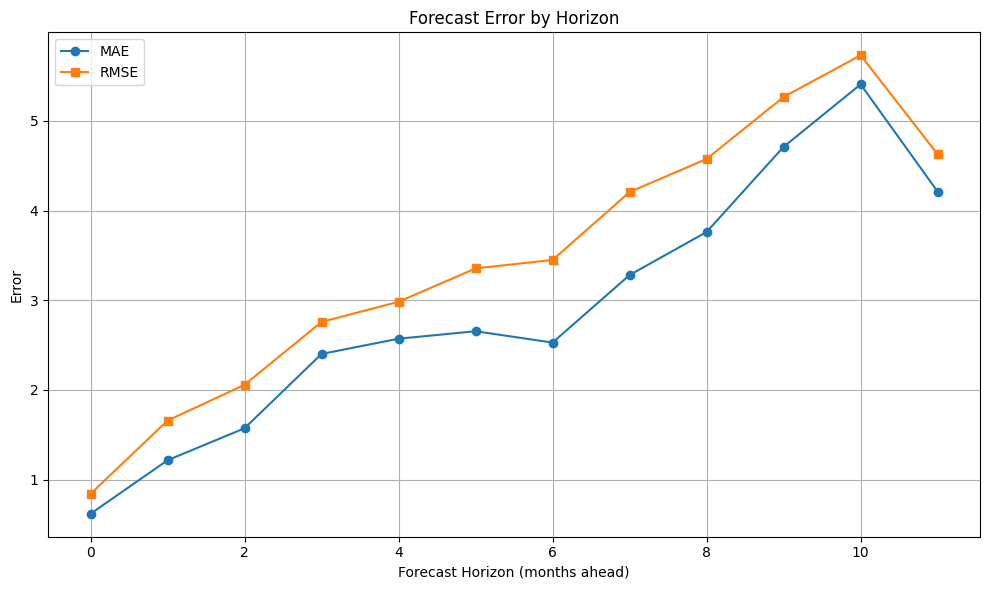

In [16]:
# Plot MAE and RMSE
plt.figure(figsize=(10, 6))
plt.plot(eval_df['Horizon'], eval_df['MAE'], marker='o', label='MAE')
plt.plot(eval_df['Horizon'], eval_df['RMSE'], marker='s', label='RMSE')
plt.xlabel('Forecast Horizon (months ahead)')
plt.ylabel('Error')
plt.title('Forecast Error by Horizon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The chart below visualizes forecast accuracy across different horizons.  

As expected, both MAE and RMSE increase with the forecast horizon, reflecting greater uncertainty the further we predict into the future.  
This pattern is typical in macroeconomic forecasting and suggests that the model performs best at short horizons (e.g., 1–3 months ahead).


The table below shows individual forecasts at horizon h = 0 (1 month ahead),  


## Forecast Details at Selected Horizon

The table below shows individual forecasts at horizon h = 0 (1 month ahead),  
including the predicted value, the actual inflation, forecast date, and the resulting errors.

In [21]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Date,Inflation forecast,Horizon,Forecast_made_in,y_true,error,abs_error,squared_error
0,2023-02-01,7.677740,0,2023-01-01,7.601,0.076740,0.076740,0.005889
12,2023-03-01,7.601107,0,2023-02-01,6.733,0.868107,0.868107,0.753609
24,2023-04-01,6.732635,0,2023-03-01,5.282,1.450635,1.450635,2.104342
36,2023-05-01,5.281644,0,2023-04-01,2.928,2.353644,2.353644,5.539642
48,2023-06-01,2.928489,0,2023-05-01,2.465,0.463489,0.463489,0.214822
60,2023-07-01,2.465203,0,2023-06-01,3.133,-0.667797,0.667797,0.445953
72,2023-08-01,3.132863,0,2023-07-01,2.437,0.695863,0.695863,0.484225
84,2023-09-01,2.437122,0,2023-08-01,0.859,1.578122,1.578122,2.490469
96,2023-10-01,0.859479,0,2023-09-01,0.085,0.774479,0.774479,0.599817
108,2023-11-01,0.085750,0,2023-10-01,0.600,-0.514250,0.514250,0.264453


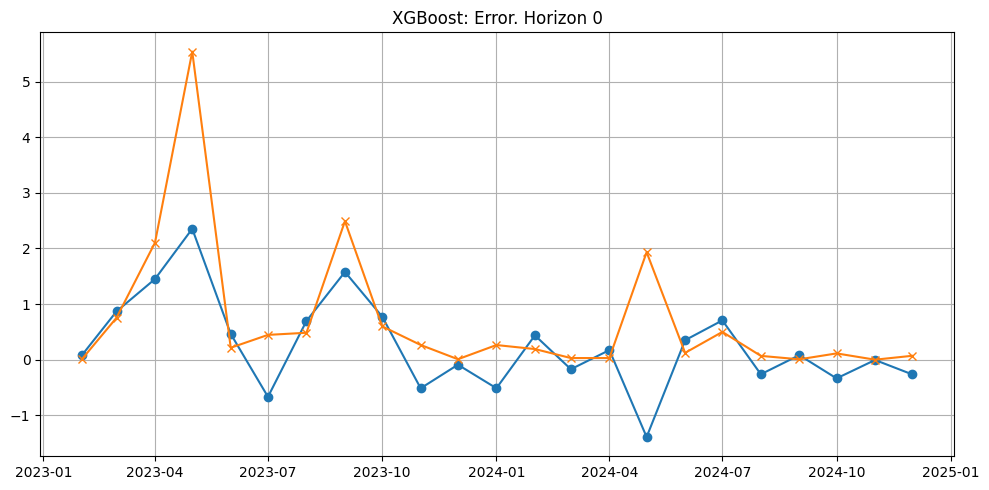

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Date"], h1["error"], label="error", marker="o")
plt.plot(h1["Date"], h1["squared_error"], label="abs_error", marker="x")
plt.title(f"XGBoost: Error. Horizon 0")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
h6 = merged_df[merged_df["Horizon"] == 6]